# Entity extraction

In [1]:
import pandas as pd
import numpy as np
import re

## 1. Loading the data

In [2]:
excel1 = "corpus_three_annot.xlsx"
excel2 = "corpus_two_annot.xlsx"
corpus1 = pd.read_excel(excel1)
corpus2 = pd.read_excel(excel2)

### 1. 1. Annotated corpus

In [3]:
corpus1 = corpus1[["id_segment", 'text_segment', "relevance_label", "relevance_type_norm"]]
print("Lenght corpus 1 : {}".format(len(corpus1.index)))

Lenght corpus 1 : 161


In [4]:
corpus2 = corpus2[["id_segment", 'text_segment', "relevance_label", "relevance_type_norm"]]
print("Lenght corpus 2 : {}".format(len(corpus2.index)))

Lenght corpus 2 : 169


In [5]:
annotated_corpus = pd.concat([corpus1, corpus2])
len(annotated_corpus.index)

330

In [6]:
pd.DataFrame(annotated_corpus["relevance_label"].value_counts())

,relevance_label
0,218
1,71
2,41


In [7]:
annotated_corpus.head()

,id_segment,text_segment,relevance_label,relevance_type_norm
0,1-s2.0-S0301479717300713-main_226b,"#text': '(Lambin et al., 2003)'}], '#text': 'W...",0,NaN
1,1-s2.0-S0303243414001718-main_19b,#text': 'After the droughts in the 1970s and 1...,2,"LULCC, DRIVERS"
2,1-s2.0-S030438781000043X-mainext_313b,#text': 'Few investment opportunities are avai...,0,NaN
3,1-s2.0-S095937809800003X-main_75b,#text': 'Pastoral production has often existed...,1,PRACTICES
4,1-s2.0-S0006320709005400-main_16b,#text': 'The forests of West and Central Afric...,2,LULC


### 1. 2. All corpus

In [8]:
all_corpus = pd.read_excel("all_corpus_processed.xlsx")

In [9]:
len(all_corpus.index)

20345

### 1.3. Cleaning text

In [10]:
def clean_text(text):
    text = str(text)
    # Use a regular expression to find and remove anything between curly braces
    cleaned_text = re.sub(r'\{.*?\}', ' ', text)

    # Use a regular expression to remove all occurrences of '#text':
    cleaned_text = re.sub(r"'#text':", '', cleaned_text)

    cleaned_text = re.sub(r"'#text':", '', cleaned_text)
    # Use a regular expression to remove all occurrences of '@xmlns':
    cleaned_text = re.sub(r"'@xmlns':", '', cleaned_text)

    # Use a regular expression to remove all occurrences of '<variable>: {'
    cleaned_text = re.sub(r"'\w+':\s*", ' ', cleaned_text)

    # Remove any sequence of more than two special characters or spaces
    cleaned_text = re.sub(r'[^a-zA-Z0-9 .%]+', ' ', cleaned_text)

    # Clean up excessive spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

In [12]:
annotated_corpus['cleaned_text'] = annotated_corpus['text_segment'].apply(clean_text)

## 2. Entity extraction

In [13]:
import spacy
import json
from spacy.matcher import Matcher
from spacy.pipeline import EntityRuler
from spacy.tokens import Span
from spacy.util import filter_spans

### 2.1. Nomenclature

In [14]:
# Extraction of a list of words, based on their lemma:
lulc_voc = pd.read_csv("data/LULC.csv")
lulc_voc = list(set([x.strip() for x in lulc_voc['LULC'] ]))
lulc_process = pd.read_csv("data/LCprocess.csv")
lulc_process = [x.strip() for x in lulc_process['process'] ]

### 2.2. NER pipeline

In [15]:

nlp = spacy.load("en_core_web_sm")

patterns = [
    {
        "label": "SURFACE_UNIT",
        "pattern": [{"LOWER": {'REGEX': "(kilometers|km²|ha|acres|hectares)[ .]?"}}]
    },

        {
        "label": "COORDINATES",
        "pattern": [{"TEXT":{'REGEX': r'\b\d{1,3}\s*°\s*[NSEW]\s*–\s*\d{1,3}\s*°\s*[NSEW]\b'}}]
    },
    {"label": "CHANGE", "pattern": [{"LEMMA": "(increase|decrease|loss|losses|gain|gains|expansion|expand)"}]},

        {
        "label": "CHANGE",
        "pattern": [{"LOWER": {'REGEX': "(increase|decrease|south|loss|losses|gain|gains|expansion|expand)[ .]?"}}]
    }
]



# Initialiser l'EntityRuler et ajouter les modèles
ruler = nlp.add_pipe("entity_ruler", before="ner")


# Add the custom component to the pipeline
ruler.add_patterns(patterns)


# Generate patterns dynamically
def create_pattern_sw(list_of_words, label) :
    pattern_list = []
    
    # single_words
    single_words = [w for w in list_of_words if len(w.split(' ')) == 1]
    
    pattern_list = [{"label": label, "pattern": [{"TEXT": word}]} for word in single_words]
    pattern_list = pattern_list + [{"label": label, "pattern": [{"LEMMA": word}]} for word in single_words]     
   
    return(pattern_list)

lulc_pattern = create_pattern_sw(lulc_voc, label = 'LULC')
lulc_process_pattern = create_pattern_sw(lulc_process, label = 'LULC_process')

# Add the custom component to the pipeline
ruler.add_patterns(lulc_pattern)
ruler.add_patterns(lulc_process_pattern)



def extract_entities(text):
    rows = list()

    # Tester la pipeline

    # Tester la pipeline
    doc = nlp(text)


    # with all the entities extracted, except multiwords
    original_ents = list(doc.ents)


    # ____________________________________________
    # Add this part at the end of your entity extraction pipeline
    # ____________________________________________

     # single_words
    multi_words_process = [w for w in lulc_process if len(w.split(' ')) > 1]
    multi_words_lemma_process = [" ".join([token.lemma_ for token in nlp(w)]) for w in multi_words_process]

    mwt_ents = []
    for mw in multi_words_process :
        for match in re.finditer(mw, doc.text):
            start, end = match.span()
            span = doc.char_span(start, end)
            if span is not None:
                mwt_ents.append((span.start, span.end, span.text))
    for mw in multi_words_lemma_process :
        for match in re.finditer(mw, doc.text):
            start, end = match.span()
            span = doc.char_span(start, end)
            if span is not None:
                mwt_ents.append((span.start, span.end, span.text))

    for ent in mwt_ents:
        start, end, name = ent
        per_ent = Span(doc, start, end, label="LULC_process")
        original_ents.append(per_ent)

     # single_words
    multi_words_lulc = [w for w in lulc_voc if len(w.split(' ')) > 1]
    multi_words_lemma_lulc = [" ".join([token.lemma_ for token in nlp(w)]) for w in multi_words_lulc]

    mwt_ents = []
    for mw in multi_words_lulc :
        for match in re.finditer(mw, doc.text):
            start, end = match.span()
            span = doc.char_span(start, end)
            if span is not None:
                mwt_ents.append((span.start, span.end, span.text))
    for mw in multi_words_lemma_lulc :
        for match in re.finditer(mw, doc.text):
            start, end = match.span()
            span = doc.char_span(start, end)
            if span is not None:
                mwt_ents.append((span.start, span.end, span.text))

    for ent in mwt_ents:
        start, end, name = ent
        per_ent = Span(doc, start, end, label="LULC")
        original_ents.append(per_ent)    
    #pour ne retenir que les spans le splus longs:
    
    filtered = filter_spans(original_ents)
    doc.ents = filtered

    # Ajouter l'EntityRuler à la pipeline

    for ent in doc.ents:
        rows.append((ent.text, ent.label_))
    return(pd.DataFrame(rows))

In [16]:
from tqdm import tqdm

df_entities = pd.DataFrame()

for i, row in tqdm(annotated_corpus.iterrows()) :
    df_tmp = extract_entities(row['cleaned_text'])
    df_tmp['id_segment'] = row['id_segment']
    df_tmp['relevance'] = row['relevance_label']
    df_entities = pd.concat([df_entities, df_tmp])

330it [03:52,  1.42it/s]


In [17]:
df_entities.columns = ['value', 'entity_label', "id_segment", "relevance"]

In [18]:
df_entities

,value,entity_label,id_segment,relevance
0,Lambin et al,PERSON,1-s2.0-S0301479717300713-main_226b,0
1,2003,DATE,1-s2.0-S0301479717300713-main_226b,0
2,LULCC,ORG,1-s2.0-S0301479717300713-main_226b,0
0,the 1970s,DATE,1-s2.0-S0303243414001718-main_19b,2
1,1980s,DATE,1-s2.0-S0303243414001718-main_19b,2
...,...,...,...,...
1,urban,LULC,1-s2.0-S0304387816300670-main_6,0
0,loss,CHANGE,1-s2.0-S0006320709005400-main_162,0
1,forest,LULC,1-s2.0-S0006320709005400-main_162,0
2,tree,LULC,1-s2.0-S0006320709005400-main_162,0


In [19]:
entities_keep = ['CHANGE', 'LULC_process','CARDINAL','LOC', 'DATE', 'LULC','PERCENT', 'GPE', 'NORP', 'SURFACE_UNIT']

In [20]:
df_entities_sub = df_entities[df_entities['entity_label'].isin(entities_keep)]

In [21]:
def replace_loc(x):
    if (x == 'GPE' or x == 'NORP') :
        return('LOC')
    else :
        return(x)

In [22]:
df_entities_sub['entity_label'] = df_entities_sub['entity_label'].apply(lambda x:replace_loc(x))

C:\Users\valentin\AppData\Local\Temp\ipykernel_5160\4213499162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_entities_sub['entity_label'] = df_entities_sub['entity_label'].apply(lambda x:replace_loc(x))


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Étape 1 : Compter le nombre de lignes par segment pour chaque relevance
segment_counts = df_entities_sub.groupby(['id_segment', 'relevance']).size().reset_index(name='count')

# Étape 2 : Créer un boxplot pour visualiser la distribution des comptes par relevance
plt.figure(figsize=(10, 6))
sns.boxplot(x='relevance', y='count', data=segment_counts, palette='pastel')

# Titre et labels
plt.title('Distribution du nombre d\'entités par segment')
plt.xlabel('Pertinence')
plt.ylabel('Nombre d\'entités par segment')
plt.xticks(ticks=[0, 1, 2], labels=['Classe 0', 'Classe 1', 'Classe 2'])
# Afficher le graphique
# Exporter la figure
plt.savefig('nombre_moyen_occurrences_labels.png', bbox_inches='tight', dpi=300)  # Spécifiez le nom du fichier et les 
plt.show()

<Axes: xlabel='count', ylabel='entity_label'>

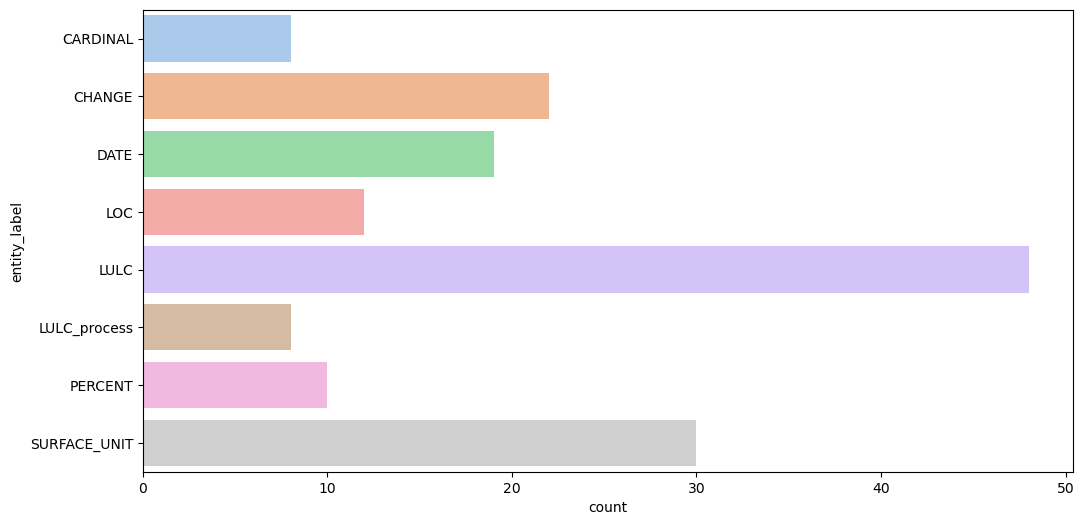

In [298]:
# Étape 1 : Compter le nombre d'occurrences de chaque label d'entité par segment
label_counts = df_entities_sub[df_entities_sub['relevance']==2].groupby(['id_segment', 'entity_label']).size().reset_index(name='count')

# Étape 2 : Calculer la moyenne des occurrences pour chaque label
mean_counts = label_counts.groupby('entity_label')['count'].sum().reset_index()

# Étape 3 : Créer un barplot des moyennes par label d'entité
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='entity_label', data=mean_counts, palette='pastel')


In [340]:
len(set(label_counts[(label_counts['relevance'] ==2)]['id_segment'].tolist()))

31

In [341]:
len(set(label_counts[(label_counts['relevance'] ==2) & (label_counts['entity_label'] == 'LULC_process') & (label_counts['count'] >0)]['id_segment'].tolist()))

8

In [342]:
len(set(label_counts[(label_counts['relevance'] ==2) & (label_counts['entity_label'] == 'PERCENT') & (label_counts['count'] >0)]['id_segment'].tolist()))

7

In [338]:
len(set(label_counts[(label_counts['relevance'] ==2) & (label_counts['entity_label'] == 'LOC') & (label_counts['count'] >0)]['id_segment'].tolist()))

10

In [339]:
len(set(label_counts[(label_counts['relevance'] ==2) & (label_counts['entity_label'] == 'DATE') & (label_counts['count'] >0)]['id_segment'].tolist()))

12